In [1]:
import os 

In [2]:
data = "datas\\names.txt" 
data_path = os.path.join(os.getcwd(),data)

In [3]:
text_data = open(data_path,"r").read().splitlines()
type(text_data)

list

In [4]:
chars   = sorted(list(set("".join(text_data))))
stoi    = {s:i+1 for i,s in enumerate(chars)} 
stoi["."] = 0
itos    = {s:i for i,s in sorted((stoi.items()))}

In [5]:
import torch
import torch.nn.functional as F

## Build dataset

In [6]:
from itertools import islice # Use itertools to avoid creating large intermediate lists

def make_dataset(data:list,block_size:int):
    X, Y = [], []
    
    for w in text_data:
        # Create a generator for the padded text to avoid large memory allocation
        padded_text = islice([0] * (block_size - 1), block_size - 1)
        padded_text = list(padded_text) + [stoi[char] for char in w + "."]

        for i in range(len(w)):
            X.append(padded_text[i:i + block_size])
            Y.append(padded_text[i + block_size])
    X = torch.tensor(X,dtype=torch.int32,device="cuda")            
    Y = torch.tensor(Y,dtype=torch.int32,device="cuda")
    return X,Y 

#x_data,y_data = make_dataset(data=text_data,block_size=3)
X,Y = make_dataset(data=text_data,block_size=3)

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-26_at_2.17.37_PM.png)



## About the Model

we have vocabulary of 27 character convert into 2 diamesional vectors. 
- In this model, we take 3 previous characters(word) for predict the next character(word) in a seequence. Basically we pass index of words (incoming words). These is a look up table `C`. This lookup table is a matrix (27,2). This is a embedding vector of words in a vocabulary. 
- Each lookup table consist of (1*2) diamensional vector.  so total (1 * 2) (1 * 2) (1 * 2)
- Then we have hidden layer of NN,
    - The size of NN is a hyperparameter, ie we can change it according to design of the model, 
    - All neural network is fully connected to 2 characters. ((1 * 2) (1 *2) (1 * 2)), and use `tanh() activation function`. 
- Then we have output layer with 27, and its fully connected to previous layer (hidden layer), and apply softmax over it. 
    - We have 27 logits (output), 


    ## Build datasets

In [7]:
block_size = 3
X,Y = [],[]

for word in text_data[:5]:

    context = [0] * block_size
    for char in word +".":
        idx = stoi[char]
        X.append(context)
        Y.append(idx)
        #print(''.join(itos[i] for i in context), '--->', itos[idx])
        context = context[1:] + [idx] # crop and append
  
X = torch.tensor(X,dtype=torch.int32,device="cuda")
Y = torch.tensor(Y,dtype=torch.int32,device="cuda") 

In [8]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int32, torch.Size([32]), torch.int32)

## Create Look-up table

In [9]:
import torch
import torch.nn.functional as F

In [10]:
C = torch.randn((27,2),device="cuda") # character embedding

In [11]:
# indexing using list 
C[[0,0,0]]

tensor([[-0.5574,  0.3876],
        [-0.5574,  0.3876],
        [-0.5574,  0.3876]], device='cuda:0')

In [12]:
C[X].shape
# this means , we have 32 characters and 3*2 is its diamensions,

torch.Size([32, 3, 2])

"C[X] means indexing into C to retrieve the relevant embedding vectors according to the input values in X. For example, consider the word ["e", "m", "m"] with corresponding embedding indices [5, 13, 13]. If C has a shape of (228146, 3), where each row represents a 3-dimensional embedding vector, then C[X] will return the embedding vectors for the indices in X."



In [13]:
embeding = C[X] 
embeding.shape

torch.Size([32, 3, 2])

## Hidden layer

In [14]:
w1 = torch.randn((embeding.shape[1] * embeding.shape[2],100),requires_grad=True,device="cuda") # (3*2,100) ==> 6 input * 100 neurons 
b1 = torch.randn((100,),requires_grad=True,device="cuda")  # 100 neurons 

- embedding.shape = (32,3,2)
- w1.shape        = (6,100)
- b1.shape        = (100)

for operation of `embedding @ w1 + b1`, we need to make the shape of embedding (32,3,2) and w1(6,100) in a common shape like, (32,6) and (6,100) respectevily. so we concatenate them. 
- embedding consist of- 
    - 32    - characters.
    - 3     - input.
    - 2     - embedding diamension. 
- w1 consist of- 
    - 6     - input from 3 characters. (2 * 3) = 6. 2 is embedding diamension. 
    - 100   - number of neurons in hidden layer
- b1 consist of 
    - 100   - bias for each neurons. 
    


In [15]:
embeding.flatten(start_dim=1,end_dim=2).shape

torch.Size([32, 6])

- Similar methods of above operations,
    - embeding.flatten(start_dim=1,end_dim=2) == embeding.view(32,6) == torch.cat(torch.unbind(embeding,1),1) 

In [16]:
h1 = embeding.flatten(start_dim=1,end_dim=2) @ w1 + b1 
h1 = torch.tanh(h1) # activation function 

## Softmax layer (output layer)

In [17]:
w2 = torch.randn((w1.shape[1],27),requires_grad=True,device="cuda") # 100 input * 27 neurons (characters)
b2 = torch.randn((27,),requires_grad=True,device="cuda")  # 100 neurons  (characters)

In [18]:
logits          = h1 @ w2 + b2 
log_counts      = logits.exp()
probs           = log_counts / torch.sum(log_counts,dim=1,keepdim=True)
probs[0].sum() 

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [19]:
probs.shape

torch.Size([32, 27])

what does it mean by this, probs.shape = [32,27].
- We have a  size of 32, where each input (word or character) has 27 possible class probabilities after applying the softmax function. The shape probs.shape = [32, 27] means that for each of the 32 inputs, the model predicts a probability distribution across 27 output classes. In this case, 27 represents the number of classes or output units in the final layer

In [20]:
probs.shape

torch.Size([32, 27])

In [21]:
## find the probability of characters. 
pred = probs[torch.arange(32),Y]
loss = -(pred.log().mean())
loss 

tensor(13.5071, device='cuda:0', grad_fn=<NegBackward0>)

## Training Model

In [22]:
block_size = 3
X,Y = [],[]

for word in text_data[:5]:

    context = [0] * block_size
    for char in word +".":
        idx = stoi[char]
        X.append(context)
        Y.append(idx)
        #print(''.join(itos[i] for i in context), '--->', itos[idx])
        context = context[1:] + [idx] # crop and append
  
X = torch.tensor(X,device="cuda")#,dtype=torch.int32,device="cuda")
Y = torch.tensor(Y,device="cuda")#,dtype=torch.int32,device="cuda") 

In [23]:
X.shape,Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [24]:
g           = torch.Generator(device="cuda").manual_seed(2147483647)## for same producability 
C           = torch.randn((27,2),generator=g,device="cuda").to(torch.float32)

w1          = torch.randn((embeding.shape[1] * embeding.shape[2],100),device="cuda")
b1          = torch.randn((100,),device="cuda")
w2          = torch.randn((w1.shape[1],27),device="cuda")
b2          = torch.randn((27,),device="cuda") 

parameters = [C,w1,b1,w2,b2]
print(f"Total numbers of parameters = {sum(para.nelement() for para in parameters)}") 

Total numbers of parameters = 3481


In [25]:
"""embeding    = C[X]
h1          = embeding.flatten(start_dim=1,end_dim=2) @ w1 + b1 
h1          = torch.tanh(h1)
logits      = h1 @ w2 +b2 
log_counts  = logits.exp()
probs       = log_counts / torch.sum(log_counts,dim=1,keepdim=True)
pred        = probs[torch.arange(X.shape[0]),Y]

## find the loss od this model 
loss = -(probs[torch.arange(X.shape[0]),Y]).log().mean() 
loss"""

'embeding    = C[X]\nh1          = embeding.flatten(start_dim=1,end_dim=2) @ w1 + b1 \nh1          = torch.tanh(h1)\nlogits      = h1 @ w2 +b2 \nlog_counts  = logits.exp()\nprobs       = log_counts / torch.sum(log_counts,dim=1,keepdim=True)\npred        = probs[torch.arange(X.shape[0]),Y]\n\n## find the loss od this model \nloss = -(probs[torch.arange(X.shape[0]),Y]).log().mean() \nloss'

## Cross Entropy



In [26]:
"""loss = F.cross_entropy(logits,(Y.to(torch.int64)))
loss"""

'loss = F.cross_entropy(logits,(Y.to(torch.int64)))\nloss'

We got same loss as we get by previous method. This method is more efficient way of finding loss.<br>
Why we use Cross entropy ?? Reasons.....
1. Backward propagation much more easier:
    - Pytorch cluster all mathematic expresion (behind the opeartion) and make it simpler backward pass. 
    - Example:
    ```class ActivationFunction:
        def tanh():
            x = self.data
            t = (math.exp(2*x) - 1) / (math.exp(2*x) +1)
            out  = ActivationFunction(t,(self,)"tanh")
            
            def _backward(self):
                self.grad += (1 - t**2) * out.grad
            out._backward = _backward
            return out. 

        - In this code, gradient of tanh is complex math, but in this code, we use (1 - t**2) for finding gradient of the tanh().The differential of d(tanh(x)) / dx = (1-t**2)

    - So this much simpler for implement. 
3. Efficient forward pass
2. Numerical stability: 
    - The custom code calculates the probabilities (probs) by exponentiating the logits and normalizing them. This can lead to numerical instability, especially if the logits have large values, as exponentiating large values can cause overflow.
        - ```logits      = torch.tensor([1,2,-3,-100])
            log_counts  = logits.exp()
            probs       = log_counts / torch.sum(log_counts,dim=0)
            probs ===>>> tensor([2.6762e-01, 7.2748e-01, 4.9017e-03, 4.2039e-45]) we got probabilities. 
            
            - But when the datas are extreame, like  
            
            logits = torch.tensor([-100,2,-3,60,100]) 
            probs ===>>> tensor([0., 0., 0., 0., nan])

        -  Lets see how Pytorch is solving this use, 
            - Lets consider logits = torch.tensor([-5,2,-3,6,100]), pytorch internally calculate maximum value in the logits and subtract it. 
                - In this case 100 is subtract from it. logits = torch.tensor([-100,2,-3,2,100]) - 100. 
                - 

    - cross_entropy internally combines the log-softmax and negative log-likelihood loss into one function, which avoids the need to explicitly calculate probabilities and prevents potential numerical issues.


In [27]:
for para in parameters:
    para.requires_grad  = True

In [28]:
from tqdm import tqdm

for _ in tqdm(range(1000), desc="Training Progress"):

    # Forward pass
    embedding   = C[X]
    h1          = embedding.flatten(start_dim=1, end_dim=2) @ w1 + b1 
    h1          = torch.tanh(h1)
    logits      = h1 @ w2 + b2 
    loss        = F.cross_entropy(logits, Y)

    #backward pass 
    for para in parameters:
        para.grad           = None
    loss.backward()
    for para in parameters:
        para.data += -0.1 * para.grad 

print(loss.item())


Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 767.53it/s]

0.2549278140068054


In [29]:
logits.max(1)

torch.return_types.max(
values=tensor([ 9.3229, 13.9209, 22.9748, 13.4482, 14.4749,  9.3229, 15.4705, 17.0799,
        18.8344, 14.7359, 15.5859, 16.2477,  9.3229, 15.2561, 17.0289, 17.7170,
         9.3229, 15.8680, 16.1391, 15.6610, 16.5086, 14.4685, 14.7413, 13.0151,
        15.8180,  9.3229, 13.7883, 17.8257, 16.3205, 15.1273, 14.3174, 16.8153],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0],
       device='cuda:0'))

In [30]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='cuda:0')

You can vitness some of the data are predicting wrongly, 
- Because X dataset contain
    - [.,.,.] = ["e"]
    - [.,.,.] = ["a"]
    - [.,.,.] = ["m"]
    - [.,.,.] = ["o"] this makes model confuse the prediction, overfitting the data points. 


## Datasets (full dataset) 

### Mini- batch


In [31]:
block_size = 3
X,Y = [],[]

for word in text_data:

    context = [0] * block_size
    for char in word +".":
        idx = stoi[char]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]
  
X = torch.tensor(X,device="cuda")
Y = torch.tensor(Y,device="cuda")

In [32]:
## initialize the parameters 
g           = torch.Generator(device="cuda").manual_seed(2147483647)## for same producability 
C           = torch.randn((27,2),generator=g,device="cuda").to(torch.float32)

w1          = torch.randn((embeding.shape[1] * embeding.shape[2],100),device="cuda")
b1          = torch.randn((100,),device="cuda")
w2          = torch.randn((w1.shape[1],27),device="cuda")
b2          = torch.randn((27,),device="cuda") 

parameters = [C,w1,b1,w2,b2]

In [33]:
for para in parameters:
    para.requires_grad = True

In [34]:
for _ in tqdm(range(1000), desc="Training Progress"):

    # mini-batch (32 is batch size)
    ix          = torch.randint(0,X.shape[0],(32,))  
    # Forward pass
    embedding   = C[X[ix]]
    h1          = embedding.flatten(start_dim=1, end_dim=2) @ w1 + b1 
    h1          = torch.tanh(h1)
    logits      = h1 @ w2 + b2 
    loss        = F.cross_entropy(logits, Y[ix])

    #backward pass 
    for para in parameters:
        para.grad           = None
    loss.backward()
    for para in parameters:
        para.data += -0.1 * para.grad 

print(loss.item())

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 605.63it/s]

2.9309616088867188


The trainig of entire dataset required lot of time, so we use **Mini_batch** for loading the dataset into the traning. 


## Plot the loss between different learning rate

In [35]:
class SimpleModel:
    def __init__(self, X, Y, emb_size, n_hidden: int, n_output: int):
        self.X          = X
        self.Y          = Y
        self.emb_size   = emb_size
        self.n_hidden   = n_hidden
        self.n_output   = n_output

        self.g = torch.Generator(device="cuda").manual_seed(2147483647)
        self.init_parameters()

    def init_parameters(self):
        self.C   = torch.randn((self.emb_size),generator=self.g,device="cuda")#.to(torch.float32)
        self.w1  = torch.randn((self.X.shape[1] * self.C.shape[1],self.n_hidden),device="cuda")
        self.b1  = torch.randn((self.n_hidden,),device="cuda")
        self.w2  = torch.randn((self.n_hidden,self.n_output),device="cuda") 
        self.b2  = torch.randn((self.n_output,),device="cuda") 

    def training(self, mini_batch:int=32, n_iteration: int = 100,learning_rate:int=0.01):

        parameters = [self.C, self.w1, self.b1, self.w2, self.b2]
        for para in parameters:
            para.requires_grad = True

        loss_list = []
        for _ in tqdm(range(n_iteration), desc=f"Training Progress (Batch Size {mini_batch})"):
            ix      = torch.randint(0, self.X.shape[0], (mini_batch,))
            emb     = self.C[self.X[ix]]
            h1      = emb.flatten(start_dim=1,end_dim=2) @ self.w1 + self.b1
            h1      = torch.tanh(h1)
            logits  = h1 @ self.w2 + self.b2
            loss    = F.cross_entropy(logits, self.Y[ix])

            # Backward pass and weight update
            for para in parameters:
                para.grad = None
            loss.backward() 
            for para in parameters:
                para.data += - learning_rate * para.grad

            loss_list.append(loss.item())

        return loss_list

In [36]:
simple_model = SimpleModel(X, Y, emb_size=(27,2),n_hidden=100,n_output=27)

In [37]:
mini_batches = [8, 16, 32, 64, 128]
losses = {}

for mini_batch in mini_batches:
    simple_model.init_parameters()  # Reset parameters to the original values
    losses[mini_batch] = simple_model.training(mini_batch=mini_batch, n_iteration=250,learning_rate=0.1)

Training Progress (Batch Size 128): 100%|██████████| 250/250 [00:00<00:00, 636.16it/s]


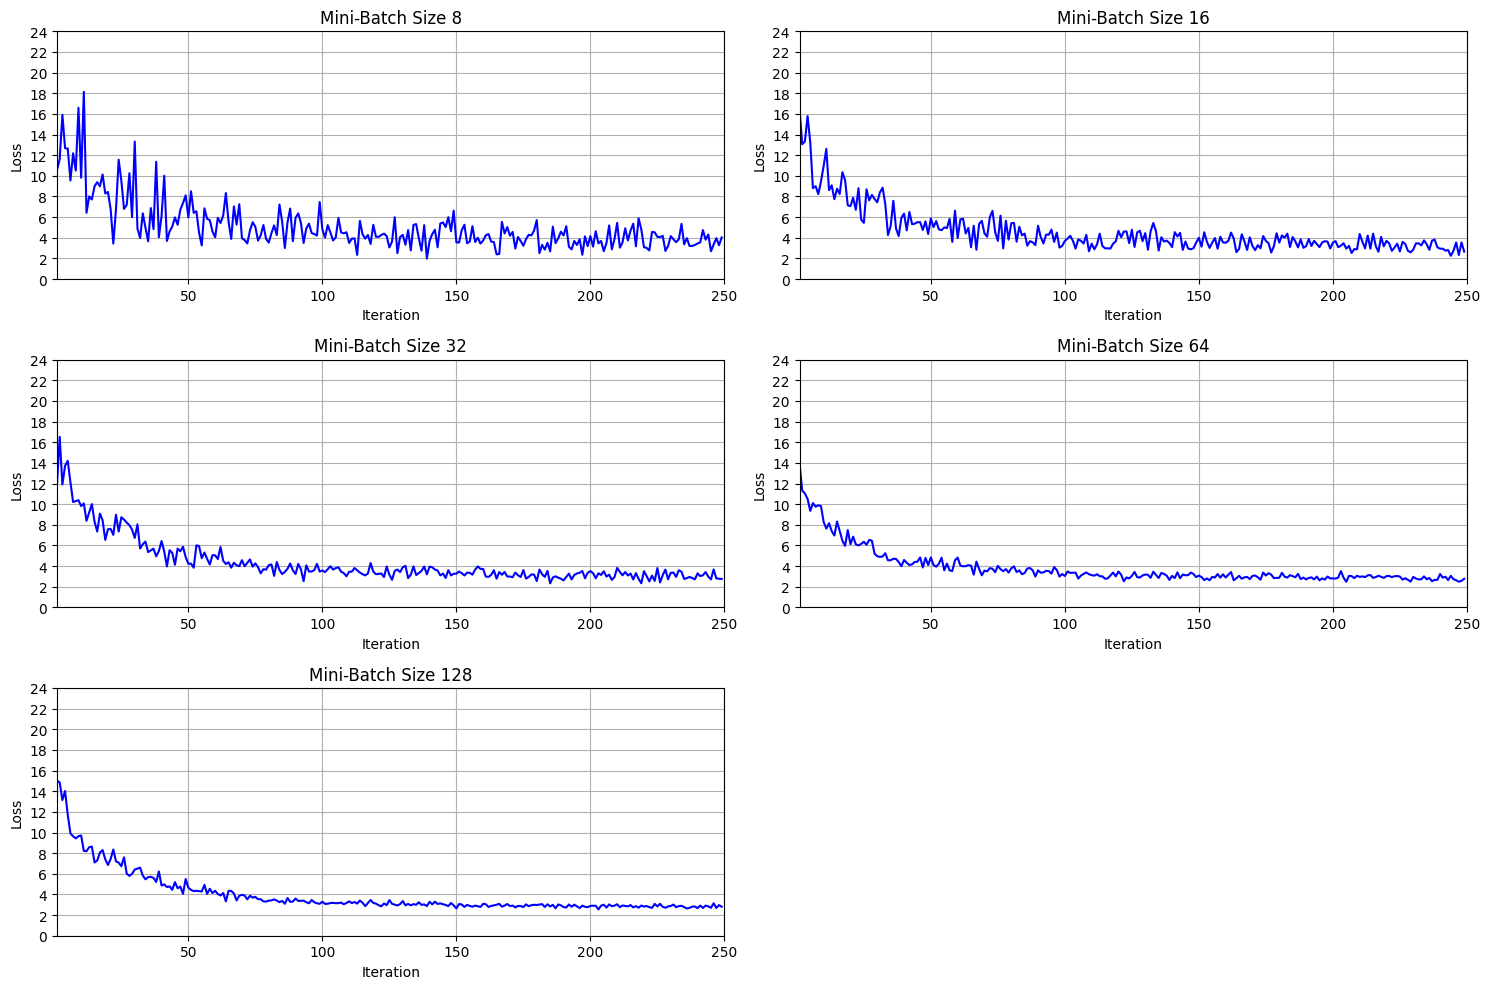

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
max_iterations = max(len(loss_list) for loss_list in losses.values())

all_losses = [loss for loss_list in losses.values() for loss in loss_list]
min_loss = int(min(all_losses)) 
max_loss = int (max(all_losses)) + 4

x_range = (min_loss, max_iterations)  # Assuming 100 iterations
y_ticks = torch.arange(0, max_loss, 2)  # Custom y-ticks at intervals of 2

for i, (mini_batch, loss_list) in enumerate(losses.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(loss_list, linestyle='-', color='b')
    plt.title(f'Mini-Batch Size {mini_batch}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.xlim(x_range)  
    plt.ylim(0, y_ticks[-1]) 
    plt.yticks(y_ticks)  
    plt.grid(True)

plt.tight_layout()
plt.show()

## Choose better learning rate

In [39]:
simple_model = SimpleModel(X, Y, emb_size=(27,2),n_hidden=100,n_output=27)

Let's try to find place where loss is explode, Range of learning rate is between 0.001 to 1. 

In [40]:
lr_exp  = torch.linspace(-3,0,1000) #exponent learnig rate  # 10**-3 = 0.001, 10**0 =1 
lrs     = 10**lr_exp 

In [41]:
## initialize the parameters 
g           = torch.Generator(device="cuda").manual_seed(2147483647)## for same producability 
C           = torch.randn((27,2),generator=g,device="cuda").to(torch.float32)

w1          = torch.randn((embeding.shape[1] * embeding.shape[2],100),device="cuda")
b1          = torch.randn((100,),device="cuda")
w2          = torch.randn((w1.shape[1],27),device="cuda")
b2          = torch.randn((27,),device="cuda") 

parameters = [C,w1,b1,w2,b2]

In [42]:
for para in parameters:
    para.requires_grad = True

In [43]:
lr_list = []
loss_list = []
for i in tqdm(range(1000), desc="Training Progress"):

    ix          = torch.randint(0,X.shape[0],(32,))  
    # Forward pass
    embedding   = C[X[ix]]
    h1          = embedding.flatten(start_dim=1, end_dim=2) @ w1 + b1 
    h1          = torch.tanh(h1)
    logits      = h1 @ w2 + b2 
    loss        = F.cross_entropy(logits, Y[ix])

    #backward pass 
    for para in parameters:
        para.grad           = None
    loss.backward()
    lr = lrs[i]
    for para in parameters:
        para.data += -lr * para.grad 
    lr_list.append(lr)
    loss_list.append(loss.item())

loss_list = torch.tensor(loss_list)

Training Progress: 100%|██████████| 1000/1000 [00:01<00:00, 611.34it/s]


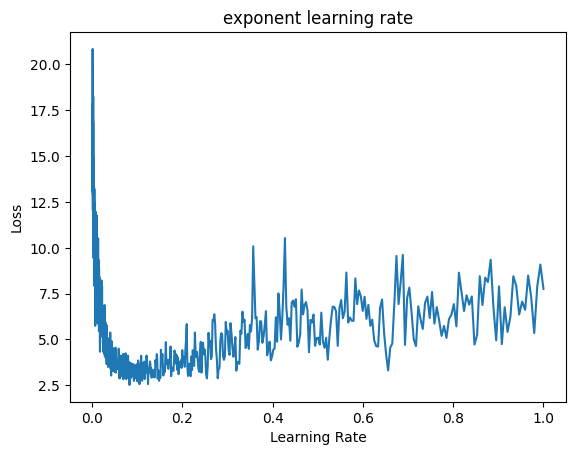

In [44]:
plt.plot(lr_list, loss_list) 
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("exponent learning rate")
plt.show()

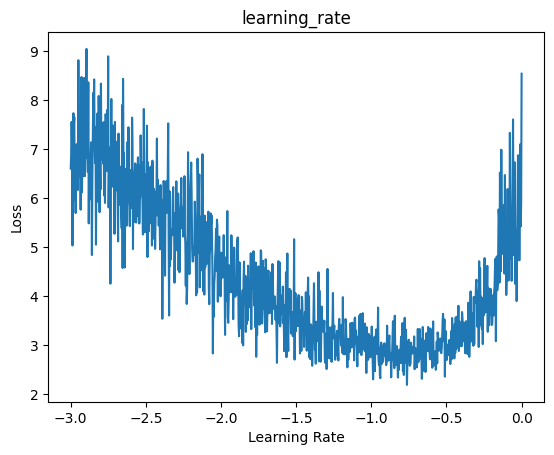

In [ ]:
plt.plot(lr_list, loss_list) 
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("learning_rate")
plt.show()

- We got 0.1 is better learning rate, ie 10**(-1) from the graph.
- 0.1 is exponent of -1, ie
    - 10 ** (-1)

## Train / Val / Test data split


- Normally we split the data into 
    - Train = 80 % 
    - Val   = 10 % 
    - test  = 10 % 
- Train dataset is used for 
    - used to optimize the parameters of the model
- Validation dataset is used for 
    - Development over all the Hyper_parameter of the model,(number of hidden layers,size of the embedding, regularization........)
- Test dataset is used for 
    - Evaluate the perfomance of  the model.  

In [46]:
def build_dataset(dataset:list=None,block_size:int=3):
    X,Y = [],[]

    for word in dataset:

        context = [0] * block_size
        for char in word +".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx] # crop and append
    
    X = torch.tensor(X,device="cuda")
    Y = torch.tensor(Y,device="cuda") 
    print(X.shape,Y.shape)
    return X,Y

In [47]:
import random


random.seed(42)
random.shuffle(text_data,random=random.seed(42))
n1 = int(0.8 * len(text_data))
n2 = int(0.9 * len(text_data))

x_train,y_train = build_dataset(text_data[:n1])
x_val,y_val     = build_dataset(text_data[n1:n2])
x_test,y_test   = build_dataset(text_data[n2:]) 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [48]:
## initialize the parameters 
g           = torch.Generator(device="cuda:0").manual_seed(2147483647)## for same producability 
C           = torch.randn((27,2),generator=g,device="cuda:0").to(torch.float32)

w1          = torch.randn((embeding.shape[1] * embeding.shape[2],100),device="cuda:0")
b1          = torch.randn((100,),device="cuda:0")
w2          = torch.randn((w1.shape[1],27),device="cuda:0")
b2          = torch.randn((27,),device="cuda:0") 

parameters = [C,w1,b1,w2,b2]

In [50]:
for para in parameters:
    para.requires_grad = True

In [51]:
for _ in tqdm(range(2000), desc="Training Progress"):

    mini_batch = 32
    ix      = torch.randint(0, x_train.shape[0], (mini_batch,))
    # Forward pass
    embedding   = C[x_train[ix]]
    h1          = embedding.flatten(start_dim=1, end_dim=2) @ w1 + b1 
    h1          = torch.tanh(h1)
    logits      = h1 @ w2 + b2 
    loss        = F.cross_entropy(logits, y_train[ix])

    #backward pass 
    for para in parameters:
        para.grad           = None
    loss.backward()
    for para in parameters:
        para.data += -0.1 * para.grad 

print(loss.item())


Training Progress: 100%|██████████| 2000/2000 [00:03<00:00, 636.73it/s]

2.4585611820220947


In [52]:
for _ in tqdm(range(1000), desc="Training Progress"):\

    mini_batch = 32
    ix      = torch.randint(0, x_val.shape[0], (mini_batch,))
    # Forward pass
    embedding   = C[x_val[ix]]
    h1          = embedding.flatten(start_dim=1, end_dim=2) @ w1 + b1 
    h1          = torch.tanh(h1)
    logits      = h1 @ w2 + b2 
    loss        = F.cross_entropy(logits, y_val[ix]) 

print(loss.item())


Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 2294.33it/s]

2.388895034790039


## Plot the Embedding


- Plot the characters between 2D embedding.
- Embedding shape is = (27,2)
    - Number of characters - 27
    - embedding diamension - 2

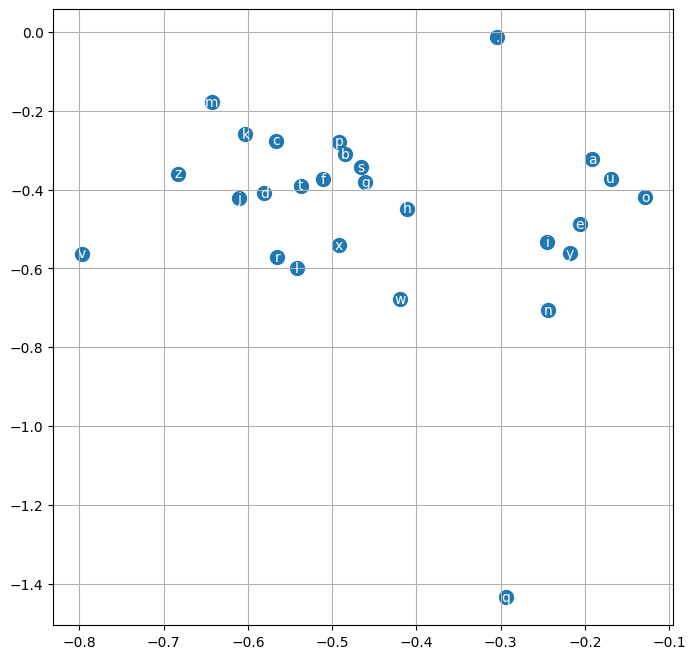

In [94]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].cpu().detach(),C[:,1].cpu().detach(),s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].cpu().detach().item(),C[i,1].cpu().detach().item(),itos[i],ha="center",va="center",color="white")
plt.grid("minor")
plt.show()

- From the scatter plot the model try to Cluster similar like characters in embedding. 
- We can see that **Vowels** (a,e,i,o,u) are clusterd in the left side. 
- **q,.,v** are embedded in seperate location (they are seperated from other characters.)